In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-19'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663912760,37615,57528,sell,0xd68bbebb8fe52ec5fcf2400ea383621ee25f3b16,NaN,1.50,sneakers,common,coacher,...,529.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.003401
1,1663912751,37614,29318,sell,0x8fa6f613865d58adac085d0566f586bd849fee80,NaN,1.13,sneakers,common,ranger,...,528.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.006826
2,1663912679,37587,49106,buy,0x402d3d216af90a41c2b00a989827a734cf9484b7,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,529.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.010239
3,1663912631,37611,37117,buy,0x271ced58130ed3c6be91e3b2e1499ca8c1f7376b,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,530.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.013652
4,1663912622,37530,48023,cancel,0x2943dfda4ecb8654155e433625cdcc8ee7faff65,NaN,NaN,sneakers,common,hiker,...,531.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.017065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47343,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
47344,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
47345,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
47346,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47348 entries, 0 to 47347
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  33738 non-null  float64
 1   time_ownership             33738 non-null  float64
 2   wallet_box_mint            33738 non-null  float64
 3   wallet_sneaker_mint        33738 non-null  float64
 4   time_level_up              30868 non-null  float64
 5   time_level_up_for_mint     33738 non-null  float64
 6   base_mint_price_amt        33738 non-null  float64
 7   base_mint_price_azy        33738 non-null  float64
 8   base_mint_price_bnb        23715 non-null  float64
dtypes: float64(9)
memory usage: 3.3 MB


In [13]:
data.genesis

0        False
1         True
2        False
3        False
4        False
         ...  
47343     True
47344    False
47345    False
47346    False
47347     True
Name: genesis, Length: 47348, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
2,1663912679,37587,49106,buy,0x402d3d216af90a41c2b00a989827a734cf9484b7,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,529.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.010239
3,1663912631,37611,37117,buy,0x271ced58130ed3c6be91e3b2e1499ca8c1f7376b,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,530.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.013652
19,1663911755,33285,19889,buy,0x720963b0e3f02afafa78c50c8312854080c26c9b,0x890b08eb7ee09e6d8bae6367204c0ed6175fff8b,1.15,sneakers,common,coacher,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.047945
20,1663911722,36564,53370,buy,0x0b5c011ad290a2b8add2c9bf8c078d85afbc4e72,0x271ced58130ed3c6be91e3b2e1499ca8c1f7376b,5.25,sneakers,uncommon,coacher,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.051370
23,1663911569,37606,29202,buy,0x2712e8f4ba5988577a2c10617d27aea0c8f44313,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.69,sneakers,common,ranger,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47285,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
47308,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
47322,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
47327,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [16]:
data['mint'].isna().sum()

0

In [17]:
data[data['level'] == 9]['mint'].value_counts()

2.0    107
0.0     54
3.0     29
1.0     19
Name: mint, dtype: int64

In [18]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
250,1663891969,36423,18112,buy,0xeb931e6f15eaa0909e30e4c7f8f237a31a7d5262,0x141039ae81d48259417e62ea83d77623c98824b0,1.80,sneakers,common,hiker,...,494.0,8374.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.099237
303,1663888765,37014,31150,buy,0x57e92dbbff9fd26e16eb554935863c03665fc720,0xd1089b976ee093104af119bbbe1075adcd7973b8,2.49,sneakers,common,ranger,...,491.0,8371.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.175097
665,1663876699,37155,24226,buy,0xf985c5e862aeddea5faedabb639eed7629696cba,0xfc2eb423826124d624db5f7d1a43f8f826750efe,1.25,sneakers,common,sprinter,...,472.0,8359.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,83.0,1.083650
774,1663874017,37169,36633,buy,0x09594e999058185d71378392a707b864b9d6cf40,0xc13d54961621af9284b165e07bd9af8fae605232,3.50,sneakers,uncommon,hiker,...,474.0,8348.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,83.0,1.142857
1229,1663858361,36137,14594,buy,0xa16490625d7c1335ae6407fce0b84ddcf57356f6,0x8b8d817666fe50f5a7e882a9a971185940fc7943,1.60,sneakers,common,ranger,...,456.0,8339.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,85.0,1.194093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42720,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
43496,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
44649,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
45010,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8982 entries, 2 to 47341
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8982 non-null   int64  
 1   mrk_id                                           8982 non-null   int64  
 2   token_id                                         8982 non-null   int64  
 3   event                                            8982 non-null   object 
 4   wallet_from                                      8982 non-null   object 
 5   wallet_to                                        8982 non-null   object 
 6   price                                            8982 non-null   float64
 7   item_type                                        8982 non-null   object 
 8   rarity                                           8982 non-null   object 
 9   sneaker_type                 

In [20]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8982 entries, 2 to 47341
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  8982 non-null   float64
 1   time_ownership             8982 non-null   float64
 2   wallet_box_mint            8982 non-null   float64
 3   wallet_sneaker_mint        8982 non-null   float64
 4   time_level_up              8982 non-null   float64
 5   time_level_up_for_mint     8982 non-null   float64
 6   base_mint_price_amt        8982 non-null   float64
 7   base_mint_price_azy        8982 non-null   float64
 8   base_mint_price_bnb        6592 non-null   float64
dtypes: float64(9)
memory usage: 701.7 KB


In [21]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
2,1.663171e+09,741779.0,2.0,5.0,900.0,1800.0,300.0,200.0,0.637124
3,1.660910e+09,1017248.0,1.0,3.0,900.0,1800.0,300.0,200.0,0.637124
19,1.658160e+09,3604277.0,11.0,14.0,900.0,1800.0,300.0,200.0,0.634107
20,1.657800e+09,78747.0,13.0,38.0,0.0,1800.0,1200.0,800.0,2.536426
23,1.657815e+09,3260974.0,5.0,4.0,900.0,1800.0,300.0,200.0,0.634107
...,...,...,...,...,...,...,...,...,...
47285,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
47308,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
47322,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
47327,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [22]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [23]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [24]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [25]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8982 entries, 2 to 47341
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8982 non-null   int64  
 1   mrk_id                                           8982 non-null   int64  
 2   token_id                                         8982 non-null   int64  
 3   event                                            8982 non-null   object 
 4   wallet_from                                      8982 non-null   object 
 5   wallet_to                                        8982 non-null   object 
 6   price                                            8982 non-null   float64
 7   item_type                                        8982 non-null   object 
 8   rarity                                           8982 non-null   object 
 9   sneaker_type                 

In [27]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
2,1663912679,37587,49106,buy,0x402d3d216af90a41c2b00a989827a734cf9484b7,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,529.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.010239
3,1663912631,37611,37117,buy,0x271ced58130ed3c6be91e3b2e1499ca8c1f7376b,0x913bbbca4e95f28836f60a44055846f6a3243c53,0.72,sneakers,common,sprinter,...,530.0,8383.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.013652
19,1663911755,33285,19889,buy,0x720963b0e3f02afafa78c50c8312854080c26c9b,0x890b08eb7ee09e6d8bae6367204c0ed6175fff8b,1.15,sneakers,common,coacher,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.047945
20,1663911722,36564,53370,buy,0x0b5c011ad290a2b8add2c9bf8c078d85afbc4e72,0x271ced58130ed3c6be91e3b2e1499ca8c1f7376b,5.25,sneakers,uncommon,coacher,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.051370
23,1663911569,37606,29202,buy,0x2712e8f4ba5988577a2c10617d27aea0c8f44313,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.69,sneakers,common,ranger,...,533.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,90.0,1.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47285,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
47308,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
47322,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
47327,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [28]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [29]:
len(data)

8982

In [30]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

8788

уберем выбросы

In [31]:
data = data[(data['price'] > 0.6)]
len(data)

8774

In [32]:
data = data[~((data['genesis']) & (data['price'] < 0.7))].copy()
len(data)

8709

In [33]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [34]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [35]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [36]:
#data['bin_level'].value_counts()

In [37]:
#data['bin_mint'].value_counts()

In [38]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [41]:
data['token_sell_activity_6H'].max()

11

In [42]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [43]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [44]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

4739

In [45]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [46]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
31360,277.756081,0.113478,0.552838,0.678822
31359,277.756081,0.113478,0.552838,0.678822
31353,278.034632,0.112454,0.552219,0.676738
31351,278.034632,0.112460,0.552195,0.676716
31339,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
9679,267.781092,0.072283,0.558802,0.680023
9674,267.402653,0.072923,0.561151,0.684100
9669,266.886342,0.072679,0.558786,0.682580
9668,266.886342,0.072679,0.558786,0.682580


In [47]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
31360,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
31359,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
31353,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
31351,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
31339,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679,267.781092,0.072283,0.558802,1.657801e+09,462.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.680023,2022-09-18 23:37:25
9674,267.402653,0.072923,0.561151,1.657812e+09,98394.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.684100,2022-09-18 23:45:05
9669,266.886342,0.072679,0.558786,1.657830e+09,3991726.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.682580,2022-09-18 23:48:20
9668,266.886342,0.072679,0.558786,1.659446e+09,21525.0,10.0,8.0,900.0,1800.0,300.0,200.0,0.682580,2022-09-18 23:51:56


In [49]:
train_data.base_mint_price_azy.value_counts()

200.0     4413
800.0      323
3200.0       3
Name: base_mint_price_azy, dtype: int64

In [50]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [51]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [52]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.87s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.83s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.83s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.84s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.83s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:12,  1.82s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:14,  1.82s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:16,  1.82s/it]iteritems is deprec

In [53]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.906,0.0728
MAE,0.094,0.0187
MSE,0.152,0.1837
RMSE,0.348,0.1799
MAPE,0.057,0.0042


In [54]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.906,0.0728
MAE,0.094,0.0187
MSE,0.152,0.1837
RMSE,0.348,0.1799
MAPE,0.057,0.0042


In [55]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.887, 'MAE': 0.094, 'MSE': 0.152, 'RMSE': 0.39, 'MAPE': 0.057}

In [56]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


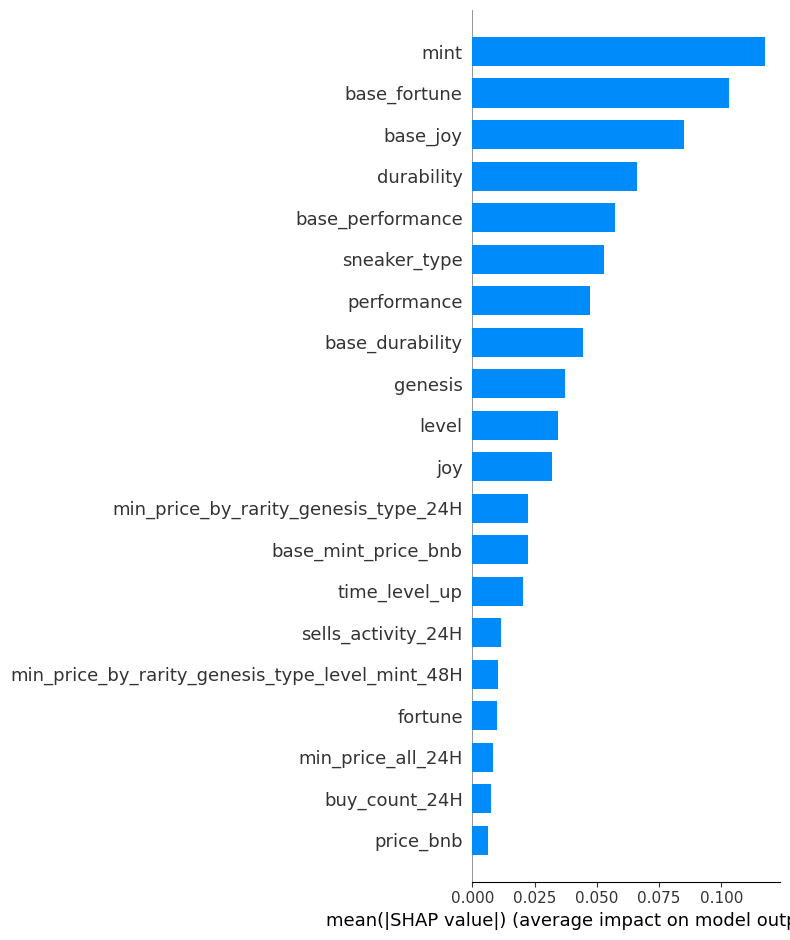

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [58]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.052353
0:	learn: 1.1151248	total: 3.09ms	remaining: 3.09s
1:	learn: 1.0721909	total: 6.33ms	remaining: 3.16s
2:	learn: 1.0328693	total: 8.86ms	remaining: 2.94s
3:	learn: 0.9940788	total: 10.7ms	remaining: 2.66s
4:	learn: 0.9583337	total: 12.5ms	remaining: 2.48s
5:	learn: 0.9243369	total: 14.3ms	remaining: 2.38s
6:	learn: 0.8927231	total: 16.1ms	remaining: 2.28s
7:	learn: 0.8639008	total: 17.9ms	remaining: 2.22s
8:	learn: 0.8354593	total: 19.7ms	remaining: 2.17s
9:	learn: 0.8078728	total: 21.6ms	remaining: 2.14s
10:	learn: 0.7815028	total: 23.4ms	remaining: 2.1s
11:	learn: 0.7568817	total: 25.2ms	remaining: 2.08s
12:	learn: 0.7325176	total: 27.1ms	remaining: 2.05s
13:	learn: 0.7094533	total: 28.9ms	remaining: 2.03s
14:	learn: 0.6882473	total: 30.7ms	remaining: 2.02s
15:	learn: 0.6672633	total: 32.4ms	remaining: 1.99s
16:	learn: 0.6469894	total: 34.1ms	remaining: 1.97s
17:	learn: 0.6277590	total: 36.1ms	remaining: 1.97s
18:	learn: 0.6110974	total: 38ms	remaining: 1

In [59]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.91, 'MAE': 0.1, 'MSE': 0.072, 'RMSE': 0.268, 'MAPE': 0.074}

In [60]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.91, 'MAE': 0.1, 'MSE': 0.072, 'RMSE': 0.268, 'MAPE': 0.074}

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.91, 'MAE': 0.1, 'MSE': 0.072, 'RMSE': 0.268, 'MAPE': 0.074}

## Fit full Model

In [62]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.054455
0:	learn: 1.0655389	total: 2.57ms	remaining: 2.57s
1:	learn: 1.0228022	total: 5.42ms	remaining: 2.71s
2:	learn: 0.9816491	total: 7.95ms	remaining: 2.64s
3:	learn: 0.9446834	total: 10.3ms	remaining: 2.56s
4:	learn: 0.9084157	total: 12.4ms	remaining: 2.46s
5:	learn: 0.8733679	total: 14.6ms	remaining: 2.43s
6:	learn: 0.8403797	total: 16.6ms	remaining: 2.36s
7:	learn: 0.8105840	total: 18.7ms	remaining: 2.32s
8:	learn: 0.7826731	total: 20.8ms	remaining: 2.29s
9:	learn: 0.7533691	total: 22.8ms	remaining: 2.26s
10:	learn: 0.7263149	total: 24.9ms	remaining: 2.24s
11:	learn: 0.7026090	total: 26.9ms	remaining: 2.21s
12:	learn: 0.6798457	total: 29.9ms	remaining: 2.27s
13:	learn: 0.6566613	total: 32ms	remaining: 2.25s
14:	learn: 0.6353106	total: 34.1ms	remaining: 2.24s
15:	learn: 0.6166855	total: 36.1ms	remaining: 2.22s
16:	learn: 0.5978486	total: 38.3ms	remaining: 2.21s
17:	learn: 0.5796096	total: 40.4ms	remaining: 2.2s
18:	learn: 0.5622299	total: 42.5ms	remaining: 2

### Test

In [63]:
i=1800

In [64]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                            hiker
genesis                                                 False
level                                                     5.0
base_performance                                          4.1
base_fortune                                              9.6
base_joy                                                  3.6
base_durability                                           8.3
performance                                              21.1
fortune                                                  14.6
joy                                                       5.6
durability                                               12.3
mint                                                      2.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.824451
min_pric

In [65]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [66]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.832

In [67]:
data.iloc[i]['price']

0.73

iteritems is deprecated and will be removed in a future version. Use .items instead.


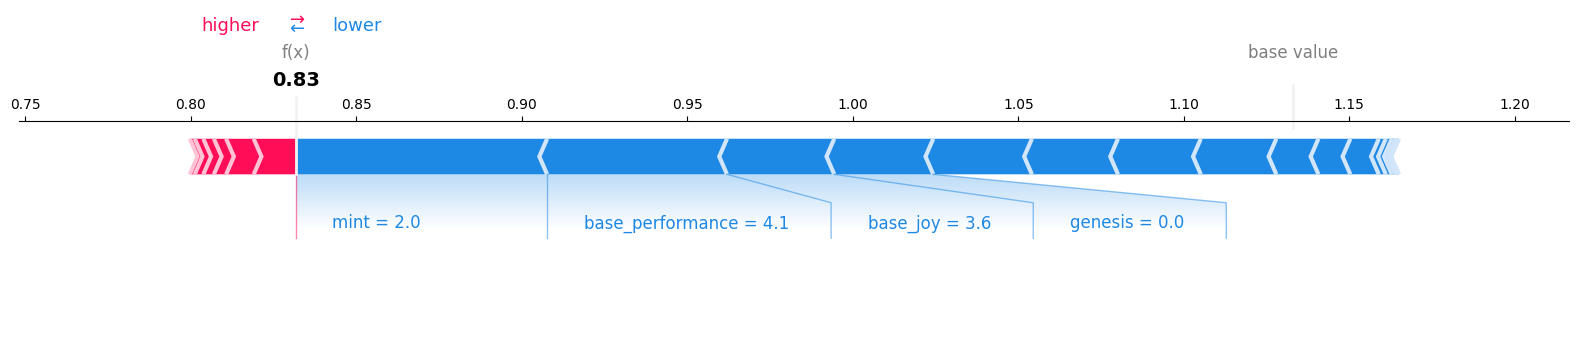

In [68]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [69]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [70]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [71]:
X.genesis.value_counts()

False    4470
True     1610
Name: genesis, dtype: int64

In [72]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,common,sprinter,False,0.0,4.7,1.4,9.6,1.3,4.7,1.4,9.6,1.3,0.0
6076,uncommon,coacher,False,0.0,12.8,17.5,13.2,20.1,12.8,17.5,13.2,20.1,0.0
6077,common,coacher,True,5.0,7.3,1.1,7.9,2.2,18.8,1.6,11.9,10.2,2.0
6078,common,sprinter,False,5.0,3.6,8.1,1.3,2.2,14.6,12.1,1.8,9.2,2.0


In [73]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.64s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.63s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:04,  1.63s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:06,  1.64s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:08,  1.63s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:09,  1.62s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:11,  1.62s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:13,  1.62s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:14,  1.62s/it]iteritems is deprec

In [74]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.897,0.0613
MAE,0.109,0.0177
MSE,0.159,0.1660
RMSE,0.366,0.1620
MAPE,0.070,0.0043


In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.897,0.0613
MAE,0.109,0.0177
MSE,0.159,0.1660
RMSE,0.366,0.1620
MAPE,0.070,0.0043


In [76]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.882, 'MAE': 0.109, 'MSE': 0.159, 'RMSE': 0.399, 'MAPE': 0.07}

In [77]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


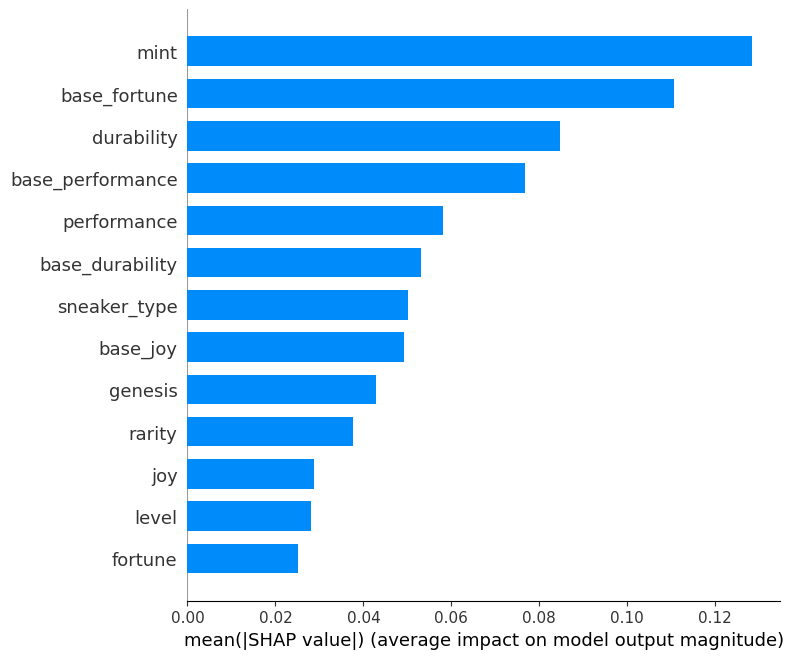

In [78]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [79]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [80]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.052353
0:	learn: 1.1148693	total: 1.47ms	remaining: 1.47s
1:	learn: 1.0716836	total: 3.99ms	remaining: 1.99s
2:	learn: 1.0318693	total: 6.75ms	remaining: 2.24s
3:	learn: 0.9938525	total: 8.9ms	remaining: 2.22s
4:	learn: 0.9560527	total: 10.8ms	remaining: 2.15s
5:	learn: 0.9208009	total: 12.3ms	remaining: 2.04s
6:	learn: 0.8874977	total: 14ms	remaining: 1.98s
7:	learn: 0.8587829	total: 15.6ms	remaining: 1.93s
8:	learn: 0.8314548	total: 17.2ms	remaining: 1.9s
9:	learn: 0.8036249	total: 18.9ms	remaining: 1.87s
10:	learn: 0.7782061	total: 20.4ms	remaining: 1.83s
11:	learn: 0.7544563	total: 22.1ms	remaining: 1.82s
12:	learn: 0.7319824	total: 23.9ms	remaining: 1.81s
13:	learn: 0.7095106	total: 25.6ms	remaining: 1.8s
14:	learn: 0.6874465	total: 27.2ms	remaining: 1.78s
15:	learn: 0.6680648	total: 28.8ms	remaining: 1.77s
16:	learn: 0.6472707	total: 30.6ms	remaining: 1.77s
17:	learn: 0.6308067	total: 32.3ms	remaining: 1.76s
18:	learn: 0.6134871	total: 34ms	remaining: 1.75s

{'R2': 0.914, 'MAE': 0.112, 'MSE': 0.068, 'RMSE': 0.262, 'MAPE': 0.088}

## Fit full Base model

In [81]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.054455
0:	learn: 1.0643343	total: 2.31ms	remaining: 2.31s
1:	learn: 1.0195643	total: 4.75ms	remaining: 2.37s
2:	learn: 0.9785539	total: 7.33ms	remaining: 2.44s
3:	learn: 0.9378589	total: 9.42ms	remaining: 2.35s
4:	learn: 0.9011749	total: 11.3ms	remaining: 2.24s
5:	learn: 0.8681264	total: 13ms	remaining: 2.15s
6:	learn: 0.8352604	total: 15ms	remaining: 2.13s
7:	learn: 0.8047420	total: 17ms	remaining: 2.1s
8:	learn: 0.7758813	total: 18.3ms	remaining: 2.01s
9:	learn: 0.7486284	total: 20.2ms	remaining: 2s
10:	learn: 0.7238811	total: 22.1ms	remaining: 1.99s
11:	learn: 0.6989032	total: 23.9ms	remaining: 1.97s
12:	learn: 0.6759486	total: 25.9ms	remaining: 1.97s
13:	learn: 0.6534762	total: 27.8ms	remaining: 1.96s
14:	learn: 0.6325793	total: 29.8ms	remaining: 1.96s
15:	learn: 0.6142399	total: 31.8ms	remaining: 1.96s
16:	learn: 0.5968847	total: 33.7ms	remaining: 1.95s
17:	learn: 0.5796149	total: 35.6ms	remaining: 1.94s
18:	learn: 0.5618192	total: 37.5ms	remaining: 1.94s
19

### Test

In [82]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [83]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.196

iteritems is deprecated and will be removed in a future version. Use .items instead.


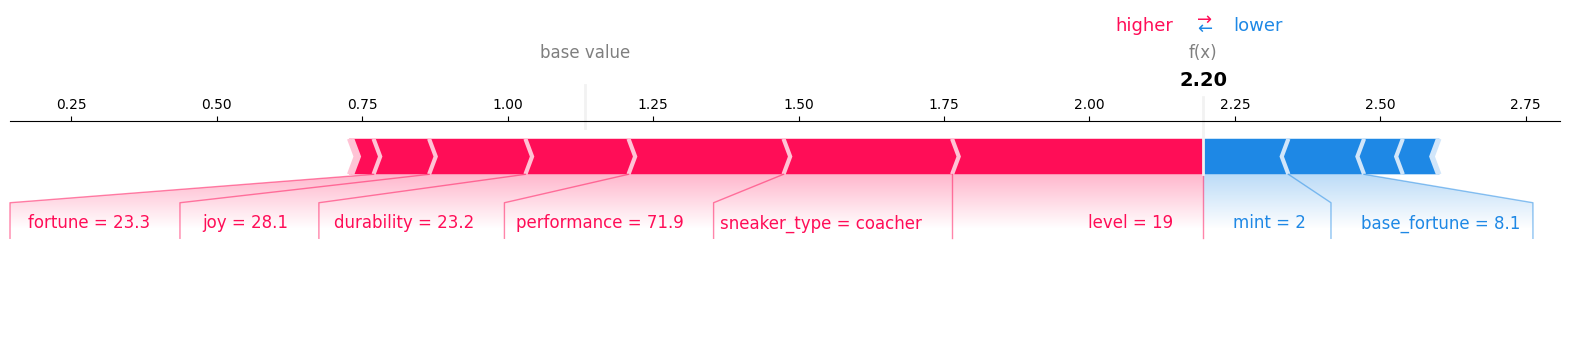

In [84]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


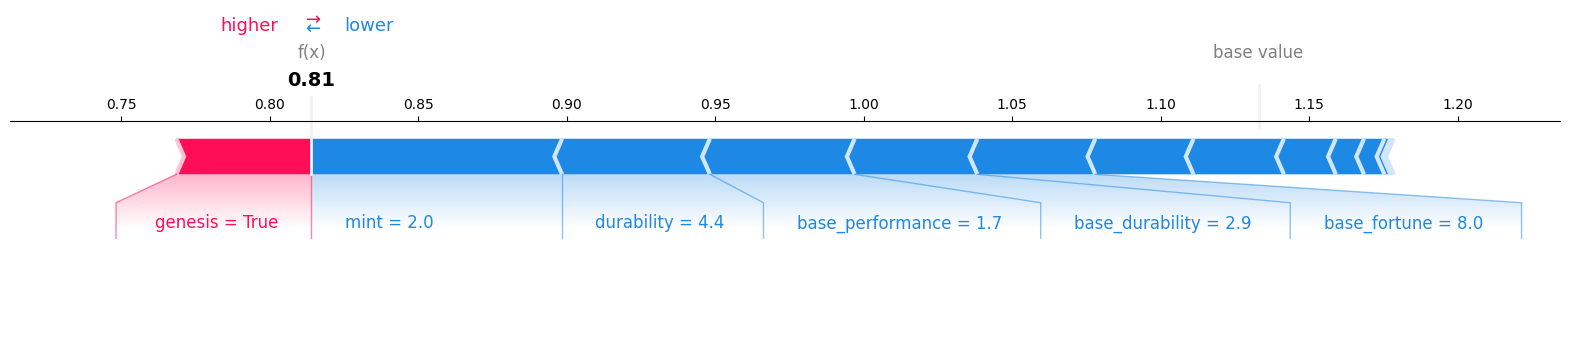

In [85]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [86]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [87]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


In [88]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [89]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663907619,37562,53945,buy,0x1072fe5ff0e32ec3d16ab8d3001b05c650eb2258,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,1.15,box,common,NaN,...,530.0,8381.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,91.0,1.166667
1,1663885274,37111,56065,buy,0xa52d66b4253eb4a70b7c1b2a4266649a53d8ebf6,0x593639c67271b82564b4ed5c67cf210a8b696037,1.04,box,common,NaN,...,482.0,8370.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,89.0,1.119048
2,1663869811,36777,56045,buy,0x316bef3dd7a0d69e0cbd3f1448de756c4dc6e0b9,0xb2b6f46e6e4e1f6a97e3efaf5bf39764d69a1262,1.00,box,common,NaN,...,446.0,8354.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,81.0,0.975610
3,1663869718,37096,56719,buy,0x30fbafda2a2764b4b8a59f60e975bb903b6db28c,0xb2b6f46e6e4e1f6a97e3efaf5bf39764d69a1262,1.00,box,common,NaN,...,448.0,8354.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,82.0,1.000000
4,1663869349,36852,56388,buy,0xaef116cf2314f181cd2e916b42354c50af05e200,0x57e92dbbff9fd26e16eb554935863c03665fc720,1.14,box,common,NaN,...,450.0,8355.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,83.0,1.024390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
924,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
925,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
926,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [90]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [91]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [92]:
len(data)

928

In [93]:
len(data[data.date >= START_DATE])

562

In [94]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [95]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
557,1.661104e+09,18458.0,5.0,4.0,NaN,1800.0,300.0,200.0,0.643484
558,1.658900e+09,2285.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.643108
559,1.658651e+09,22068.0,5.0,2.0,NaN,1800.0,300.0,200.0,0.643155
560,1.657805e+09,16039.0,11.0,11.0,NaN,1800.0,300.0,200.0,0.637755


In [96]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
557,1663869349,36852,56388,buy,False,hiker,ranger,2022-09-22 17:55:49
558,1663869718,37096,56719,buy,False,sprinter,sprinter,2022-09-22 18:01:58
559,1663869811,36777,56045,buy,False,sprinter,sprinter,2022-09-22 18:03:31
560,1663885274,37111,56065,buy,False,hiker,sprinter,2022-09-22 22:21:14


In [97]:
data.genesis.value_counts()

False    521
True      41
Name: genesis, dtype: int64

In [98]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [99]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [100]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [101]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,1663869349,36852,56388,buy,0xaef116cf2314f181cd2e916b42354c50af05e200,0x57e92dbbff9fd26e16eb554935863c03665fc720,1.14,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
558,1663869718,37096,56719,buy,0x30fbafda2a2764b4b8a59f60e975bb903b6db28c,0xb2b6f46e6e4e1f6a97e3efaf5bf39764d69a1262,1.00,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
559,1663869811,36777,56045,buy,0x316bef3dd7a0d69e0cbd3f1448de756c4dc6e0b9,0xb2b6f46e6e4e1f6a97e3efaf5bf39764d69a1262,1.00,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
560,1663885274,37111,56065,buy,0xa52d66b4253eb4a70b7c1b2a4266649a53d8ebf6,0x593639c67271b82564b4ed5c67cf210a8b696037,1.04,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0


In [102]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [103]:
data['ranger_hiker'].sum()

59

## FE

In [104]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [105]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [106]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [107]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:03,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:04,  1.95it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  1.96it/s]iteritems is deprec

In [108]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.865,0.1733
MAE,0.057,0.0109
MSE,0.012,0.0078
RMSE,0.105,0.0322
MAPE,0.044,0.0074


In [109]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.865,0.1733
MAE,0.057,0.0109
MSE,0.012,0.0078
RMSE,0.105,0.0322
MAPE,0.044,0.0074


In [110]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.939, 'MAE': 0.057, 'MSE': 0.012, 'RMSE': 0.11, 'MAPE': 0.044}

iteritems is deprecated and will be removed in a future version. Use .items instead.


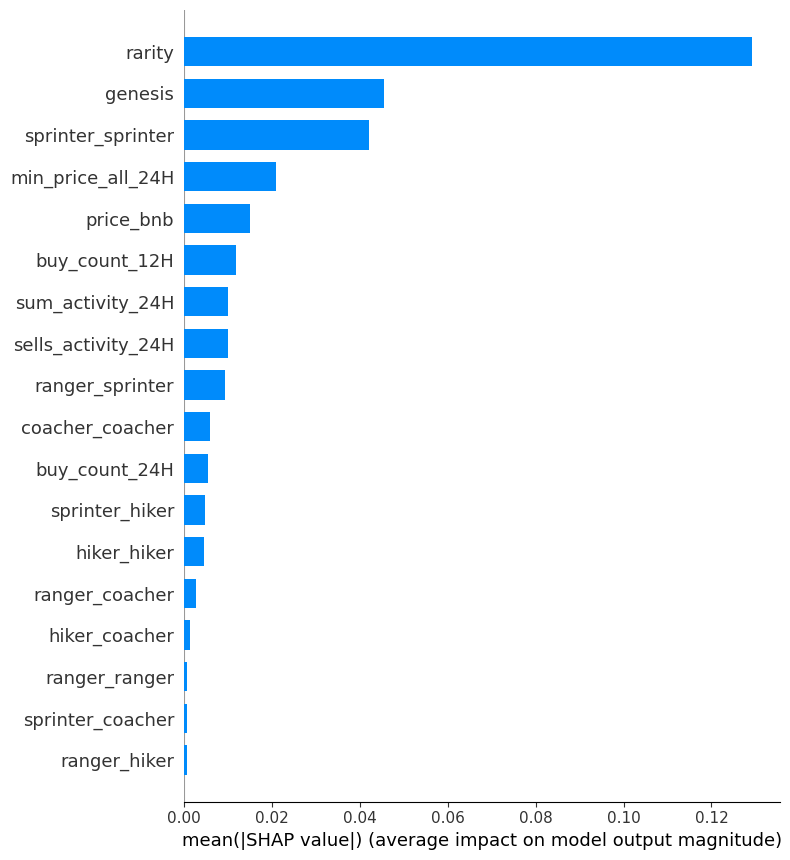

In [111]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [112]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.03738
0:	learn: 0.4356592	total: 898us	remaining: 898ms
1:	learn: 0.4259594	total: 1.56ms	remaining: 780ms
2:	learn: 0.4171718	total: 2.36ms	remaining: 784ms
3:	learn: 0.4079606	total: 3.15ms	remaining: 784ms
4:	learn: 0.3968263	total: 3.38ms	remaining: 672ms
5:	learn: 0.3854676	total: 3.78ms	remaining: 626ms
6:	learn: 0.3754205	total: 4.1ms	remaining: 582ms
7:	learn: 0.3670975	total: 4.87ms	remaining: 603ms
8:	learn: 0.3590815	total: 5.35ms	remaining: 589ms
9:	learn: 0.3507171	total: 5.63ms	remaining: 558ms
10:	learn: 0.3421470	total: 6ms	remaining: 539ms
11:	learn: 0.3334055	total: 6.2ms	remaining: 510ms
12:	learn: 0.3250045	total: 6.39ms	remaining: 485ms
13:	learn: 0.3170366	total: 7.06ms	remaining: 497ms
14:	learn: 0.3105005	total: 7.68ms	remaining: 505ms
15:	learn: 0.3028639	total: 7.86ms	remaining: 484ms
16:	learn: 0.2963815	total: 8.47ms	remaining: 490ms
17:	learn: 0.2892052	total: 9.04ms	remaining: 493ms
18:	learn: 0.2826798	total: 9.58ms	remaining: 495ms

### Test

In [113]:
i = 250

In [114]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2,
 'wallet_from_all_count': 9,
 'token_all_activity_3H': 0,
 'token_sell_activity_6H': 0,
 'buy_count_12H': 16,
 'buy_count_24H': 25,
 'buy_count_48H': 55,
 'sell_count_12H': 18,
 'sell_count_24H': 40,
 'sell_count_48H': 96,
 'cancel_count_12H': 9,
 'cancel_count_24H': 24,
 'cancel_coun

In [115]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H                16
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count         2
wallet_from_all_count         9
dtype: object

In [116]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.03

In [117]:
data.iloc[i]['price']

1.0

In [118]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.426

In [119]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.27

# Box Base Model

In [120]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [121]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [122]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             562 non-null    object
 1   genesis            562 non-null    bool  
 2   ranger_sprinter    562 non-null    int64 
 3   ranger_hiker       562 non-null    int64 
 4   ranger_coacher     562 non-null    int64 
 5   sprinter_hiker     562 non-null    int64 
 6   sprinter_coacher   562 non-null    int64 
 7   hiker_coacher      562 non-null    int64 
 8   ranger_ranger      562 non-null    int64 
 9   sprinter_sprinter  562 non-null    int64 
 10  hiker_hiker        562 non-null    int64 
 11  coacher_coacher    562 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 49.0+ KB


In [124]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  4.57it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  4.60it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  4.55it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:00,  4.58it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  4.59it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  4.59it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:01,  4.61it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:01,  4.62it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:01,  4.62it/s]iteritems is deprec

In [125]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.842,0.1671
MAE,0.074,0.0096
MSE,0.016,0.0078
RMSE,0.122,0.0300
MAPE,0.058,0.0060


In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.842,0.1671
MAE,0.074,0.0096
MSE,0.016,0.0078
RMSE,0.122,0.0300
MAPE,0.058,0.0060


In [127]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.92, 'MAE': 0.074, 'MSE': 0.016, 'RMSE': 0.126, 'MAPE': 0.058}

iteritems is deprecated and will be removed in a future version. Use .items instead.


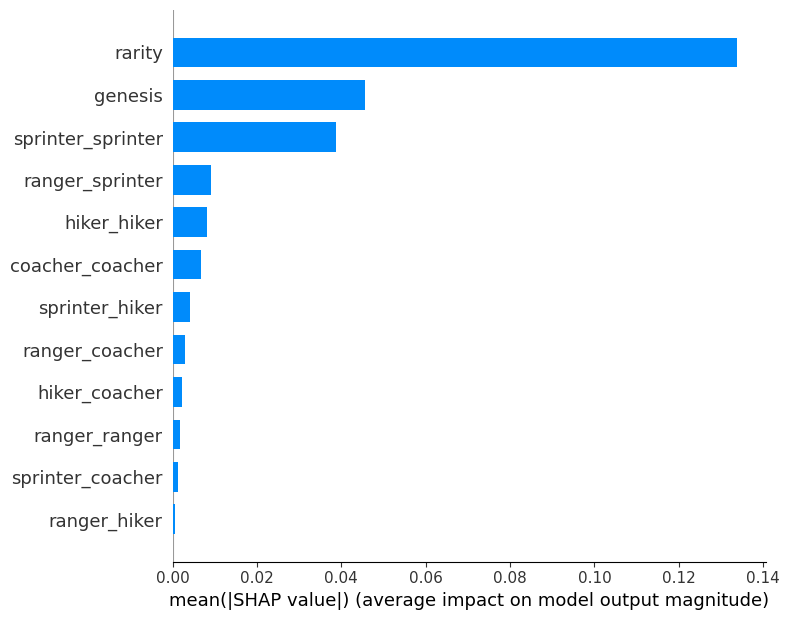

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [129]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.03738
0:	learn: 0.4313898	total: 298us	remaining: 298ms
1:	learn: 0.4194197	total: 431us	remaining: 215ms
2:	learn: 0.4078903	total: 549us	remaining: 183ms
3:	learn: 0.3959968	total: 782us	remaining: 195ms
4:	learn: 0.3843802	total: 929us	remaining: 185ms
5:	learn: 0.3740876	total: 1.21ms	remaining: 200ms
6:	learn: 0.3640362	total: 1.36ms	remaining: 194ms
7:	learn: 0.3544170	total: 1.49ms	remaining: 184ms
8:	learn: 0.3451645	total: 1.62ms	remaining: 178ms
9:	learn: 0.3362677	total: 1.74ms	remaining: 172ms
10:	learn: 0.3277158	total: 1.85ms	remaining: 166ms
11:	learn: 0.3194984	total: 1.97ms	remaining: 162ms
12:	learn: 0.3110559	total: 2.18ms	remaining: 166ms
13:	learn: 0.3032501	total: 2.42ms	remaining: 171ms
14:	learn: 0.2958621	total: 2.55ms	remaining: 168ms
15:	learn: 0.2877578	total: 2.74ms	remaining: 168ms
16:	learn: 0.2809303	total: 2.85ms	remaining: 165ms
17:	learn: 0.2743695	total: 3ms	remaining: 164ms
18:	learn: 0.2680902	total: 3.12ms	remaining: 161ms
1

## Test

In [130]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.295

In [131]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [132]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [133]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [134]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.061

In [135]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [136]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [137]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.467

In [138]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.125

In [139]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.087

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [140]:
# import ast
# import json

In [141]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [142]:
# print(json.dumps(json_data))

In [143]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [144]:
#output = json.loads(r.text)

In [145]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам